# Facial Keypoints Identification with Keras
This model looks at taking advantage of the Kaggle facial keypoints detection dataset to identify more points on a face than the nose, for example the eyes and mouth.

Sources: [here](https://medium.com/@baikaralkesha/face-detection-using-opencv-in-google-colaboratory-a7529a2bb921) and [here](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning)

## Installation
We first need to install TensorFlow 1.12 because TensorFlow 1.13 countains a BatchNormalizationV1 layer that cannot be converted to TensorFlowJS

In [1]:
!pip install tensorflow==1.12

     |████████████████████████████████| 83.1MB 38.2MB/s 
     |████████████████████████████████| 3.1MB 28.5MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


## Imports

In [2]:
from __future__ import absolute_import, division, print_function

import os
import re

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from google.colab import files
from google.colab import drive

%matplotlib inline

Using TensorFlow backend.


TensorFlow version is  1.12.0


## Data Preprocessing
We now need to get access to the data.

Data source: [here](https://www.kaggle.com/c/facial-keypoints-detection/data)

### Accessing Data
We can load the data from Google Drive

In [3]:
drive.mount('/content/gdrive')
data_path = '/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/facial_keypoints_detection/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


First, we will define the keypoints we want to import

In [0]:
keypoint_labels = ['left_eye_center', 'right_eye_center', 'mouth_center_bottom_lip']
# keypoint_labels = ['nose_tip']
keypoint_cols = np.zeros(len(keypoint_labels)).astype(int)

Now we can now set up the loading process

In [0]:
header = open(data_path + 'training.csv', 'r').readline()[:-1].split(',')
img_col = header.index('Image')

for i in range(len(keypoint_cols)):
    keypoint_cols[i] = header.index(keypoint_labels[i] + '_x')

image_size = 96
err = 0

In [0]:
def load_image(source_line, index):
    '''
    Given a source CSV file line, load the image data and a list of coordinates

    Raises Value Error!
    '''
    global err
    # Prepare the data
    data = source_line[:-1].split(',')
    image_data = [int(pix) for pix in data[img_col].split(' ')]

    # Format the data
    img = np.array(image_data).reshape((image_size, image_size))

    coors = np.zeros(keypoint_cols.shape[0] * 2)
    for i in range(len(keypoint_cols)):
      coors[i * 2] = float(data[keypoint_cols[i]])
      coors[i * 2 + 1] = float(data[keypoint_cols[i] + 1])

    return img, coors

In [0]:
train_csv = open(data_path + 'training.csv', 'r').readlines()[1:]
test_csv = open(data_path + 'test.csv', 'r').readlines()[1:]

Finally, we can test this on a single image

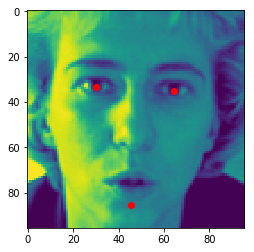

In [68]:
img, coors = load_image(train_csv[1], 1)
plt.imshow(img)
plt.scatter(coors[::2], coors[1::2], c='r')

## Create Training and Validation Arrays

In [0]:
def load_csv(lines, inds):
    '''
    For a given set of lines from a data csv, return an array of images and an 
    array of labels
    '''
    # Set up arrays
    data = np.zeros((len(inds), image_size, image_size))
    labels = np.zeros((len(inds), len(keypoint_labels) * 2))

    # Load in the data
    for i in range(inds.shape[0]):
      try:
        data[i], labels[i] = load_image(lines[inds[i]], i)
      except ValueError:
        # Note: will deal with this issue later
        pass
      
    # Remove zero data, we know that the left eye will never be at (0, 0) unless
    # there was no data there
    inds = np.logical_and(labels[:,0] > 0, labels[:,1] > 0)
    data = data[inds]
    labels = labels[inds]
        
    data = np.repeat(data[..., np.newaxis], 3, -1).astype(int)

    return data, labels

Now decide which indicies to use for training and which to use for validation. We will reserve 100 images for validation.

In [0]:
all_inds = np.arange(len(train_csv))
valid_inds = np.random.choice(all_inds, size=100, replace=False)
train_inds = all_inds[np.logical_not(np.isin(all_inds, valid_inds))]

In [0]:
train_data, train_labels = load_csv(train_csv, train_inds)
valid_data, valid_labels = load_csv(train_csv, valid_inds)

Finally make sure everything is okay by displaying an image

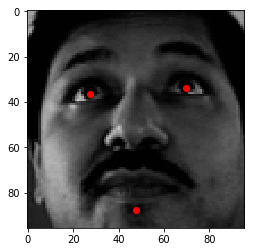

In [72]:
i = 200
plt.imshow(train_data[i])
plt.scatter([train_labels[i][::2]], [train_labels[i][1::2]], c='r')

### Create Image Data Generator with Image Augmentation
We then need to resize the images and create a data generator, to be used for training / validation

For this section, I used an additional source: [here](https://keras.io/preprocessing/image/)

In [0]:
batch_size = 128

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(train_data, train_labels,
                batch_size=batch_size)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow(valid_data, valid_labels,
                batch_size=batch_size)

## Model Set-Up

### Create the base model using a pretrained network
Here we are using MobileNet, but that can always be changed.

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                            input_shape=IMG_SHAPE, 
                                            weights='imagenet')

### Freeze the convolutional base
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.



In [0]:
base_model.trainable = False

### Now create the model to store the layers for identified facial features

In [0]:
def create_feat_model():
    '''
    Create a model to store the layers for identified facial features
    '''
    feats = tf.keras.Input(shape=(3, 3, 1280))
    pool = tf.keras.layers.GlobalAveragePooling2D()(feats)
    dense1 = tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)(pool)
    drop = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(len(keypoint_labels) * 2)(drop)
    
    return tf.keras.Model(inputs=feats, outputs=dense2)

In [0]:
feat_model = create_feat_model()

### Add back the top layers
Now let's add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
    base_model,
    feat_model
])

### Compile the model
You must compile the model before training it. For this, we will create a new metric, the distance between the ground-truth point and our point

In [0]:
def dist_pred(y_true, y_pred):
    sum_dist = 0
    for i in range(len(keypoint_labels)):
        sum_dist += K.sqrt((y_true[i * 2] - y_pred[i * 2])**2 + (y_true[i * 2 + 1] - y_pred[i * 2 + 1])**2)
    return sum_dist

In [0]:
lr = 0.0001 # 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
model_2 (Model)              (None, 6)                 1317894   
Total params: 3,575,878
Trainable params: 1,317,894
Non-trainable params: 2,257,984
_________________________________________________________________


### Train Top Layers

In [0]:
def train(lr, epochs):
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])
  steps_per_epoch = train_generator.n // batch_size
  validation_steps = max(validation_generator.n // batch_size, 1)

  history = model.fit_generator(train_generator, 
                                steps_per_epoch = steps_per_epoch,
                                epochs=epochs, 
                                workers=4,
                                validation_data=validation_generator, 
                                validation_steps=validation_steps)

In [83]:
epochs = 1
lr = 0.0001 # 0.0001
train(lr, epochs)

Epoch 1/1
53/53 [==============================] - 190s 4s/step - loss: 1795.8006 - dist_pred: 166.4878 - val_loss: 582.3519 - val_dist_pred: 114.9322


In [84]:
epochs = 1
lr = 0.00005 # 0.0001
train(lr, epochs)

Epoch 1/1
53/53 [==============================] - 191s 4s/step - loss: 379.3950 - dist_pred: 71.3572 - val_loss: 126.8167 - val_dist_pred: 35.3495


In [86]:
epochs = 1
lr = 0.00005 # 0.0001
train(lr, epochs)

Epoch 1/1
53/53 [==============================] - 188s 4s/step - loss: 95.2517 - dist_pred: 33.8276 - val_loss: 160.9968 - val_dist_pred: 32.7350


In [88]:
epochs = 1
lr = 0.00005 # 0.0001
train(lr, epochs)

Epoch 1/1
53/53 [==============================] - 188s 4s/step - loss: 76.9154 - dist_pred: 30.4622 - val_loss: 159.7373 - val_dist_pred: 36.2788


We can try out the results of our model

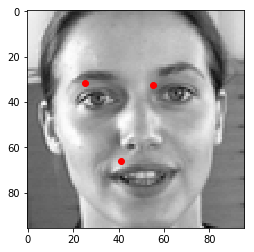

In [91]:
i = 20
pts = model.predict(np.expand_dims(train_data[i], axis=0))
plt.imshow(train_data[i])
plt.scatter(pts[0][::2], pts[0][1::2], c='r')

## Testing
We can also try this out on other data sets

In [0]:
gt_db_path = '/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/gt_db/'

Get face position

In [0]:
image = cv2.imread(gt_db_path + 's42/02.jpg')
grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/haarcascade_frontalface_default.xml')
box = face_cascade.detectMultiScale(grayscale_image, 1.25, 6)[0]

Predict eyes and mouth

In [0]:
net_data = cv2.resize(image[box[1]:(box[1]+box[3]), box[0]:(box[0] + box[2]), :], (image_size, image_size))
pts = model.predict(np.expand_dims(net_data, axis=0))

Do linear regression

In [0]:
x_weights = np.array([0.013330983, 0.36554886, 0.005527861, -0.382274539, 
                      1.01703989, 0.000242652])
x_bias = -1.34480293
y_weights = np.array([0.44016716, 0.48229461, -0.22590793, 0.53768469,
                      0.01016914, -0.00998019])
y_bias = 2.07304674

In [109]:
nose = [pts[0].dot(x_weights) + x_bias, pts[0].dot(y_weights) + y_bias]
print(nose)

[42.92063716050156, 55.71413647992729]


Plot

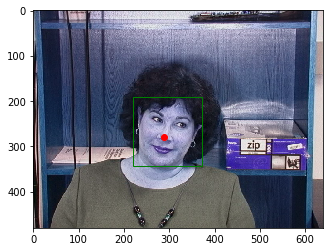

In [110]:
fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, 
                         edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.scatter(box[0] + nose[0] * box[2] / image_size, 
           box[1] + nose[1] * box[3] / image_size, c='r')

plt.show()

## Saving the Model
First recompile the model so that it no longer uses the distance measure, confirm that it is still working (rerun above), and save it

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[])

In [0]:
model.save('eyes_mouth.h5')
files.download('eyes_mouth.h5')